# BASIC STEPS IN EXPLORATORY DATA ANALYSIS

This notebook contain the main basic steps that should be performed during exploratory data analysis of experimental data for protein engineering. It is important to note that this is not an exhaustive procedure. It only include the minimal number of steps that should be performed and further steps might be required depending on the data and objective.

In [4]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import sys
import seaborn as sns

sys.path.insert(1, '/raid/data/fherrera/Protein_Engineering_Code_Center/Src/')
from data_processing import DataProcessing

The datset used in this tutorial correspond to alpha amylase obtained from: 

https://github.com/the-protein-engineering-tournament/pet-pilot-2023

In [5]:
data = pd.read_csv('../Data/raw_data/Alpha_Amylase.csv')
data.head()

,mutant,dataset,mutated_sequence,expression
0,S142L-T152P-L158V-G298M-E351Q,2,LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,0.815
1,K007D,1,LTAPSIDSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,0.830
2,A086E,1,LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,1.560
3,S005E-S131H,2,LTAPEIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,0.452
4,T413H,1,LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,1.010


The first step is to check for invalid or NaN entries. These entries must be removed as they are not useful for any prediction porpuse

In [15]:
number_of_entries = data['expression'].shape[0]
print (f'Number of entries in the raw dataset: {number_of_entries}')

Number of entries in the raw dataset: 12294


In [11]:
expression_nan_count = data['expression'].isna().sum()
print(f'Number of NaN values in expression column: {expression_nan_count}')

Number of NaN values in expression column: 924


In [16]:
data_no_nan = data.dropna(subset=['expression'])
number_of_entries_no_nan = data_no_nan['expression'].shape[0]
print(f'Number of entries in the dataset after removing NaN values: {number_of_entries_no_nan}')

Number of entries in the dataset after removing NaN values: 11370


In [20]:
data_no_nan.loc[:, 'Log_expression'] =  DataProcessing.transform_to_logarithmic(data_no_nan ['expression'])
data_no_nan .head()

,mutant,dataset,mutated_sequence,expression,Log_expression
0,S142L-T152P-L158V-G298M-E351Q,2,LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,0.815,-0.204567
1,K007D,1,LTAPSIDSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,0.830,-0.186330
2,A086E,1,LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,1.560,0.444686
3,S005E-S131H,2,LTAPEIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,0.452,-0.794073
4,T413H,1,LTAPSIKSGTILHAWNWSFNTLKHNMKDIHDAGYTAIQTSPINQVK...,1.010,0.009950


In [25]:
data_no_nan.to_csv('../Data/Cleaned_data/Alpha_Amylase_cleaned.csv', index=False)

In [22]:
data_no_nan['Log_expression'].describe()

count    11370.000000
mean        -1.111259
std          1.212110
min         -2.995732
25%         -2.302585
50%         -0.621757
75%         -0.072571
max          1.161274
Name: Log_expression, dtype: float64

Text(0, 0.5, 'Log_expression Value')

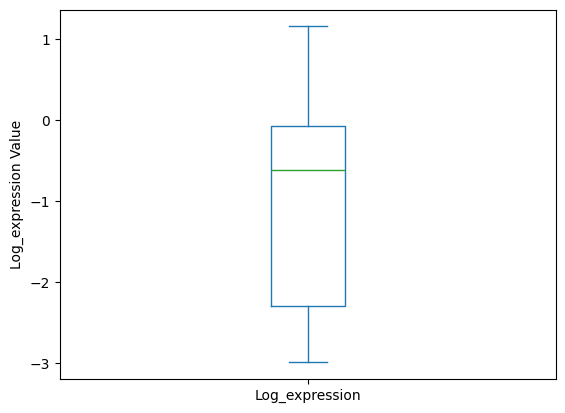

In [23]:
data_no_nan['Log_expression'].plot(kind='box')
plt.ylabel('Log_expression Value')

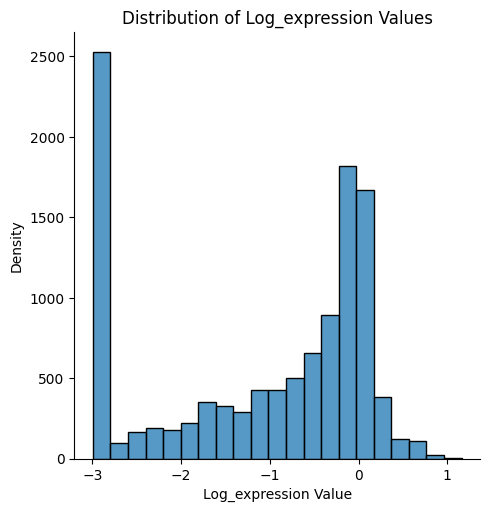

In [24]:

sns.displot(data_no_nan['Log_expression'])
plt.xlabel('Log_expression Value')
plt.ylabel('Density')
plt.title('Distribution of Log_expression Values')
plt.show()
